In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [108]:
# A table with stock, news_rank,  performance merged by date
# A table with stock, news_count, performance merged by date

import pandas as pd

data_stock = pd.read_csv('APPLE_2016_Stock.txt', sep=" ", header = None)
data_stock.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
print (len(data_stock))
print (data_stock.head())

data_news_count = pd.read_csv('APPLE_2016_News_Key_Words_Count.txt', sep=" ", header = None)
data_news_count.columns = ['Date', 'Business Week', 'CNN Money', 'Invenstor Guide', 'Market Watch', 'Yahoo Finance']
data_news_count['Business Week'] = data_news_count['Business Week'].str.strip('[]')
data_news_count['CNN Money'] = data_news_count['CNN Money'].str.strip('[]')
data_news_count['Invenstor Guide'] = data_news_count['Invenstor Guide'].str.strip('[]')
data_news_count['Market Watch'] = data_news_count['Market Watch'].str.strip('[]')
data_news_count['Yahoo Finance'] = data_news_count['Yahoo Finance'].str.strip('[]')
print (len(data_news_count))
print (data_news_count.head())

data_news_rank = pd.read_csv('APPLE_2016_News_Key_Words_Rank.txt', sep=" ", header = None)
data_news_rank.columns = ['Date', 'Business Week', 'CNN Money', 'Invenstor Guide', 'Market Watch', 'Yahoo Finance']
data_news_rank['Business Week'] = data_news_rank['Business Week'].str.strip('[]')
data_news_rank['CNN Money'] = data_news_rank['CNN Money'].str.strip('[]')
data_news_rank['Invenstor Guide'] = data_news_rank['Invenstor Guide'].str.strip('[]')
data_news_rank['Market Watch'] = data_news_rank['Market Watch'].str.strip('[]')
data_news_rank['Yahoo Finance'] = data_news_rank['Yahoo Finance'].str.strip('[]')
print (len(data_news_rank))
print (data_news_rank.head())

data_performance = pd.read_csv('APPLE_2016_Performance.txt', sep=" ", header = None)
data_performance.columns = ['Date', 'Performance']
print (len(data_performance))
print (data_performance.head())


252
         Date       Close        High         Low        Open    Volume
0  2016-01-04  105.349998  105.370003  102.000000  102.610001  67649400
1  2016-01-05  102.709999  105.849998  102.410004  105.750000  55791000
2  2016-01-06  100.699997  102.370003   99.870003  100.559998  68457400
3  2016-01-07   96.449997  100.129997   96.430000   98.680000  81094400
4  2016-01-08   96.959999   99.110001   96.760002   98.550003  70798000
252
         Date Business Week    CNN Money Invenstor Guide Market Watch  \
0  2016-01-04    0.64306868   0.57705569      0.36451626   0.43535139   
1  2016-01-05    0.65250756   0.62259887      0.36925369   0.45117851   
2  2016-01-06    0.54829005   0.48848415      0.79255722   0.40319667   
3  2016-01-07    0.53189089   0.50088329             0.2   0.43240138   
4  2016-01-08    0.49632346   0.63800835      0.55588179     0.363199   

  Yahoo Finance  
0    0.45819658  
1    0.46178081  
2    0.54041616  
3    0.59868805  
4    0.56728218  
252
         

In [112]:
stock_news_rank = pd.merge(data_stock, data_news_rank, how='left', on=['Date'])
#stock_news_rank.head(10)
stock_news_rank_performance = pd.merge(stock_news_rank, data_performance, how='left', on=['Date'])
stock_news_rank_performance.head()

,Date,Close,High,Low,Open,Volume,Business Week,CNN Money,Invenstor Guide,Market Watch,Yahoo Finance,Performance
0,2016-01-04,105.349998,105.370003,102.000000,102.610001,67649400,0.58991634,0.63638439,0.57004112,0.45975752,0.63734468,0
1,2016-01-05,102.709999,105.849998,102.410004,105.750000,55791000,0.57714306,0.62901221,0.49595102,0.44376887,0.57732601,-1
2,2016-01-06,100.699997,102.370003,99.870003,100.559998,68457400,0.55546926,0.59631545,0.43672212,0.43679802,0.58992848,0
3,2016-01-07,96.449997,100.129997,96.430000,98.680000,81094400,0.54038365,0.56368338,0.38614258,0.42151551,0.5480616,-1
4,2016-01-08,96.959999,99.110001,96.760002,98.550003,70798000,0.54628301,0.58320798,0.29610308,0.42373717,0.53947134,0


# Begin build model

In [125]:
import numpy as np
import random


np.random.seed(0)


Only_Stock = stock_news_rank_performance[['Close', 'High', 'Low', 'Open', 'Volume']]
Performance_Label = stock_news_rank_performance['Performance']
Y = Performance_Label.as_matrix()
#print (Y)
Highest_Price = Only_Stock['High'].max()
Highest_Volume = Only_Stock['Volume'].max()


# Stock only

Only_Stock_Normalized = (Only_Stock - Only_Stock.mean()) / (Only_Stock.max() - Only_Stock.min())
Only_Stock_Normalized_mat = Only_Stock_Normalized.as_matrix()

# Stock + BW

Only_Stock_Normalized_BW = Only_Stock_Normalized.as_matrix()
Business_Week_News = stock_news_rank_performance[['Business Week']].as_matrix()
Only_Stock_Normalized_BW = np.concatenate((Only_Stock_Normalized_BW, Business_Week_News), 1)

# Stock + CNN  ['Date', 'Business Week', 'CNN Money', 'Invenstor Guide', 'Market Watch', 'Yahoo Finance']

Only_Stock_Normalized_CNN = Only_Stock_Normalized.as_matrix()
CNN_News = stock_news_rank_performance[['CNN Money']].as_matrix()
Only_Stock_Normalized_CNN = np.concatenate((Only_Stock_Normalized_CNN, CNN_News), 1)

# Stock + IG

Only_Stock_Normalized_IG = Only_Stock_Normalized.as_matrix()
Inventor_Guide_News = stock_news_rank_performance[['Invenstor Guide']].as_matrix()
Only_Stock_Normalized_IG = np.concatenate((Only_Stock_Normalized_IG, Inventor_Guide_News), 1)

# Stock + MW

Only_Stock_Normalized_MW = Only_Stock_Normalized.as_matrix()
Market_Watch_News = stock_news_rank_performance[['Market Watch']].as_matrix()
Only_Stock_Normalized_MW = np.concatenate((Only_Stock_Normalized_MW, Market_Watch_News), 1)

# Stock + Yahoo

Only_Stock_Normalized_YH = Only_Stock_Normalized.as_matrix()
Yahoo_Finance_News = stock_news_rank_performance[['Yahoo Finance']].as_matrix()
Only_Stock_Normalized_YH = np.concatenate((Only_Stock_Normalized_YH, Yahoo_Finance_News), 1)

# All

Only_Stock_Normalized_ALL = Only_Stock_Normalized.as_matrix()
Only_Stock_Normalized_ALL = np.concatenate((Only_Stock_Normalized_ALL, Business_Week_News), 1)
Only_Stock_Normalized_ALL = np.concatenate((Only_Stock_Normalized_ALL, CNN_News), 1)
Only_Stock_Normalized_ALL = np.concatenate((Only_Stock_Normalized_ALL, Inventor_Guide_News), 1)
Only_Stock_Normalized_ALL = np.concatenate((Only_Stock_Normalized_ALL, Market_Watch_News), 1)
Only_Stock_Normalized_ALL = np.concatenate((Only_Stock_Normalized_ALL, Yahoo_Finance_News), 1)




print (Only_Stock_Normalized_BW[83])
shuffle = np.random.permutation(np.arange(Only_Stock_Normalized.shape[0]))
print (shuffle[0:5])

#print(Only_Stock_Normalized.head())

#print(Only_Stock_Normalized.iloc[2])

for i in range(0, len(Only_Stock_Normalized)):
    Only_Stock_Normalized_mat[i] = Only_Stock_Normalized_mat[shuffle[i]]
    Only_Stock_Normalized_BW[i] = Only_Stock_Normalized_BW[shuffle[i]]
    Only_Stock_Normalized_CNN[i] = Only_Stock_Normalized_CNN[shuffle[i]]
    Only_Stock_Normalized_IG[i] = Only_Stock_Normalized_IG[shuffle[i]]
    Only_Stock_Normalized_MW[i] = Only_Stock_Normalized_MW[shuffle[i]]
    Only_Stock_Normalized_YH[i] = Only_Stock_Normalized_YH[shuffle[i]]
    Only_Stock_Normalized_ALL[i] = Only_Stock_Normalized_ALL[shuffle[i]]
    Y[i] = Y[shuffle[i]]



print (Only_Stock_Normalized_mat[0:5])
print (Only_Stock_Normalized_BW[0:5])
print (Only_Stock_Normalized_CNN[0:5])
print (Only_Stock_Normalized_IG[0:5])
print (Only_Stock_Normalized_MW[0:5])
print (Only_Stock_Normalized_YH[0:5])
print (Only_Stock_Normalized_ALL[0:5])
print (Y[0:5])    




[-0.3376569874030698 -0.35851898999166676 -0.3577655164158694
 -0.36578356019128605 0.15127651105708478 ' 0.53737683']
[158  83 170 101 150]
[[ 0.16037239  0.1544343   0.1904832   0.16757364 -0.13447948]
 [-0.33765699 -0.35851899 -0.35776552 -0.36578356  0.15127651]
 [ 0.11092758  0.10632198  0.13651626  0.12037701 -0.09433279]
 [-0.15241882 -0.18346339 -0.15869472 -0.1798359  -0.01766645]
 [ 0.13493352  0.10891266  0.12400739  0.1068921  -0.08484657]]
[[0.16037239302983877 0.15443430194714983 0.19048320384842218
  0.16757364349927448 -0.13447947953869874 ' 0.61253172']
 [-0.3376569874030698 -0.35851898999166676 -0.3577655164158694
  -0.36578356019128605 0.15127651105708478 ' 0.53737683']
 [0.11092757747194738 0.10632198486533168 0.13651625546143872
  0.12037701468451241 -0.09433279081842824 ' 0.60218363']
 [-0.15241881975536928 -0.18346339044401333 -0.15869472312483413
  -0.17983590227787197 -0.017666449434217454 ' 0.55752638']
 [0.13493352172046846 0.1089126580569416 0.12400739019927

In [126]:

ratio = 0.7
sample_length = len(Only_Stock_Normalized)
test_end_index = int(round(sample_length * ratio)) # 61000 
dev_start_index = int(round(sample_length * ratio * 0.9)) # 60000
mini_size = test_end_index  - dev_start_index # 1000

'''
    Only_Stock_Normalized_mat[i] = Only_Stock_Normalized_mat[shuffle[i]]
    Only_Stock_Normalized_BW[i] = Only_Stock_Normalized_BW[shuffle[i]]
    Only_Stock_Normalized_CNN[i] = Only_Stock_Normalized_CNN[shuffle[i]]
    Only_Stock_Normalized_IG[i] = Only_Stock_Normalized_IG[shuffle[i]]
    Only_Stock_Normalized_MW[i] = Only_Stock_Normalized_MW[shuffle[i]]
    Only_Stock_Normalized_YH[i] = Only_Stock_Normalized_YH[shuffle[i]]
    Only_Stock_Normalized_ALL[i] = Only_Stock_Normalized_ALL[shuffle[i]]
'''

X = Only_Stock_Normalized_mat
    
Stock_test_data, Stock_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_dev_data, Stock_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_train_data, Stock_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_mini_train_data, Stock_mini_train_labels = X[:mini_size], Y[:mini_size]


X = Only_Stock_Normalized_BW
    
Stock_BW_test_data, Stock_BW_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_BW_dev_data, Stock_BW_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_BW_train_data, Stock_BW_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_BW_mini_train_data, Stock_BW_mini_train_labels = X[:mini_size], Y[:mini_size]

X = Only_Stock_Normalized_CNN
    
Stock_CNN_test_data, Stock_CNN_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_CNN_dev_data, Stock_CNN_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_CNN_train_data, Stock_CNN_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_CNN_mini_train_data, Stock_CNN_mini_train_labels = X[:mini_size], Y[:mini_size]

X = Only_Stock_Normalized_IG
    
Stock_IG_test_data, Stock_IG_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_IG_dev_data, Stock_IG_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_IG_train_data, Stock_IG_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_IG_mini_train_data, Stock_IG_mini_train_labels = X[:mini_size], Y[:mini_size]

X = Only_Stock_Normalized_MW
    
Stock_MW_test_data, Stock_MW_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_MW_dev_data, Stock_MW_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_MW_train_data, Stock_MW_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_MW_mini_train_data, Stock_MW_mini_train_labels = X[:mini_size], Y[:mini_size]

X = Only_Stock_Normalized_YH
    
Stock_YH_test_data, Stock_YH_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_YH_dev_data, Stock_YH_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_YH_train_data, Stock_YH_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_YH_mini_train_data, Stock_YH_mini_train_labels = X[:mini_size], Y[:mini_size]

X = Only_Stock_Normalized_ALL
    
Stock_ALL_test_data, Stock_ALL_test_labels = X[test_end_index: ], Y[test_end_index:]
Stock_ALL_dev_data, Stock_ALL_dev_labels = X[dev_start_index:test_end_index], Y[dev_start_index: test_end_index]
Stock_ALL_train_data, Stock_ALL_train_labels = X[:dev_start_index], Y[:dev_start_index]
Stock_ALL_mini_train_data, Stock_ALL_mini_train_labels = X[:mini_size], Y[:mini_size]

In [145]:


# BW KNN Performance

clf_BW = KNeighborsClassifier(n_neighbors=1)
clf_BW.fit(Stock_BW_mini_train_data, Stock_BW_mini_train_labels)

pred_labels = clf_BW.predict(Stock_BW_test_data)
print('For Business Week, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_BW.score(Stock_BW_test_data, \
                                                                                                Stock_BW_test_labels)) )
print(classification_report(Stock_BW_test_labels, pred_labels, digits=3))

# CNN KNN Performance

clf_CNN = KNeighborsClassifier(n_neighbors=1)
clf_CNN.fit(Stock_CNN_mini_train_data, Stock_CNN_mini_train_labels)
#clf_CNN.fit(Stock_CNN_train_data, Stock_CNN_train_labels)

pred_labels = clf_CNN.predict(Stock_CNN_test_data)
print('For CNN Money, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_CNN.score(Stock_CNN_test_data, \
                                                                                             Stock_CNN_test_labels)) )
print(classification_report(Stock_CNN_test_labels, pred_labels, digits=3))

# IG KNN Performance

clf_IG = KNeighborsClassifier(n_neighbors=1)
clf_IG.fit(Stock_IG_mini_train_data, Stock_IG_mini_train_labels)
#clf_IG.fit(Stock_IG_train_data, Stock_IG_train_labels)

pred_labels = clf_IG.predict(Stock_IG_test_data)
print('For Inventor Guide, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_IG.score(Stock_IG_test_data, \
                                                                                                Stock_IG_test_labels)) )
print(classification_report(Stock_IG_test_labels, pred_labels, digits=3))

# MW KNN Performance

clf_MW = KNeighborsClassifier(n_neighbors=1)
clf_MW.fit(Stock_MW_mini_train_data, Stock_MW_mini_train_labels)

pred_labels = clf_MW.predict(Stock_MW_test_data)
print('For Market Watch, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_MW.score(Stock_MW_test_data, \
                                                                                             Stock_MW_test_labels)) )
print(classification_report(Stock_MW_test_labels, pred_labels, digits=3))

# YH KNN Performance

clf_YH = KNeighborsClassifier(n_neighbors=1)
clf_YH.fit(Stock_YH_mini_train_data, Stock_YH_mini_train_labels)

pred_labels = clf_YH.predict(Stock_YH_test_data)
print('For Yahoo Finance, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_YH.score(Stock_YH_test_data, \
                                                                                             Stock_YH_test_labels)) )
print(classification_report(Stock_YH_test_labels, pred_labels, digits=3))




# ALL KNN Performance

clf_ALL = KNeighborsClassifier(n_neighbors=1)
clf_ALL.fit(Stock_ALL_mini_train_data, Stock_ALL_mini_train_labels)
#clf_ALL.fit(Stock_ALL_train_data, Stock_ALL_train_labels)

pred_labels = clf_ALL.predict(Stock_ALL_test_data)
print('For using all these five news, accuracy for KNN model with %d neighbors is: %0.3f' %(1, clf_ALL.score(Stock_ALL_test_data, \
                                                                                             Stock_ALL_test_labels)) )
print(classification_report(Stock_ALL_test_labels, pred_labels, digits=3))

For Business Week, accuracy for KNN model with 1 neighbors is: 0.645
             precision    recall  f1-score   support

         -1      0.143     1.000     0.250         4
          0      1.000     0.625     0.769        72
          1      0.000     0.000     0.000         0

avg / total      0.955     0.645     0.742        76

For CNN Money, accuracy for KNN model with 1 neighbors is: 0.658
             precision    recall  f1-score   support

         -1      0.148     1.000     0.258         4
          0      1.000     0.639     0.780        72
          1      0.000     0.000     0.000         0

avg / total      0.955     0.658     0.752        76

For Inventor Guide, accuracy for KNN model with 1 neighbors is: 0.684
             precision    recall  f1-score   support

         -1      0.143     1.000     0.250         4
          0      1.000     0.667     0.800        72

avg / total      0.955     0.684     0.771        76

For Market Watch, accuracy for KNN model with

/home/cloudera/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Naive Bayse

In [162]:
import numpy as np
#X = News_mini_train_data
#Y = News_mini_train_labels
X = Stock_BW_mini_train_data 
Y = Stock_BW_mini_train_labels
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB


# BW BernoulliNB Performance

#clf_BW = BernoulliNB()
clf_BW = GaussianNB()
clf_BW.fit(Stock_BW_mini_train_data, Stock_BW_mini_train_labels)

pred_labels = clf_BW.predict(Stock_BW_test_data)
print('For Business Week, accuracy for BernoulliNB model is: %0.3f' %clf_BW.score(Stock_BW_test_data, \
                                                                                                Stock_BW_test_labels) )
print(classification_report(Stock_BW_test_labels, pred_labels, digits=3))


# CNN BernoulliNB Performance

#clf_CNN = BernoulliNB()
clf_CNN = GaussianNB()
clf_CNN.fit(Stock_CNN_mini_train_data, Stock_CNN_mini_train_labels)

pred_labels = clf_CNN.predict(Stock_CNN_test_data)
print('For CNN Money, accuracy for BernoulliNB model is: %0.3f' %clf_CNN.score(Stock_CNN_test_data, \
                                                                                                Stock_CNN_test_labels) )
print(classification_report(Stock_CNN_test_labels, pred_labels, digits=3))


# IG BernoulliNB Performance

#clf_IG = BernoulliNB()
clf_IG = GaussianNB()
clf_IG.fit(Stock_IG_mini_train_data, Stock_IG_mini_train_labels)
#clf_IG.fit(Stock_IG_train_data, Stock_IG_train_labels)

pred_labels = clf_IG.predict(Stock_IG_test_data)
print('For Inventor Guide, accuracy for BernoulliNB model is: %0.3f' %clf_IG.score(Stock_IG_test_data, \
                                                                                                Stock_IG_test_labels) )
print(classification_report(Stock_IG_test_labels, pred_labels, digits=3))

# MW BernoulliNB Performance

#clf_MW = BernoulliNB()
clf_MW = GaussianNB()
clf_MW.fit(Stock_MW_mini_train_data, Stock_MW_mini_train_labels)

pred_labels = clf_MW.predict(Stock_MW_test_data)
print('For Market Watch, accuracy for BernoulliNB model is: %0.3f' %clf_MW.score(Stock_MW_test_data, \
                                                                                             Stock_MW_test_labels) )
print(classification_report(Stock_MW_test_labels, pred_labels, digits=3))

# YH BernoulliNB Performance

#clf_YH = BernoulliNB()
clf_YH = GaussianNB()
clf_YH.fit(Stock_YH_mini_train_data, Stock_YH_mini_train_labels)

pred_labels = clf_YH.predict(Stock_YH_test_data)
print('For Yahoo Finance, accuracy for BernoulliNB model is: %0.3f' %clf_YH.score(Stock_YH_test_data, \
                                                                                             Stock_YH_test_labels) )
print(classification_report(Stock_YH_test_labels, pred_labels, digits=3))




# ALL BernoulliNB Performance

#clf_ALL = BernoulliNB()
clf_ALL = GaussianNB()
clf_ALL.fit(Stock_ALL_mini_train_data, Stock_ALL_mini_train_labels)
#clf_ALL.fit(Stock_ALL_train_data, Stock_ALL_train_labels)

pred_labels = clf_ALL.predict(Stock_ALL_test_data)
print('For using all these five news, accuracy for BernoulliNB model is: %0.3f' %clf_ALL.score(Stock_ALL_test_data, \
                                                                                             Stock_ALL_test_labels) )
print(classification_report(Stock_ALL_test_labels, pred_labels, digits=3))


For Business Week, accuracy for BernoulliNB model is: 0.776
             precision    recall  f1-score   support

         -1      0.158     0.750     0.261         4
          0      0.982     0.778     0.868        72

avg / total      0.939     0.776     0.836        76

For CNN Money, accuracy for BernoulliNB model is: 0.776
             precision    recall  f1-score   support

         -1      0.158     0.750     0.261         4
          0      0.982     0.778     0.868        72

avg / total      0.939     0.776     0.836        76

For Inventor Guide, accuracy for BernoulliNB model is: 0.921
             precision    recall  f1-score   support

         -1      0.400     1.000     0.571         4
          0      1.000     0.917     0.957        72

avg / total      0.968     0.921     0.936        76

For Market Watch, accuracy for BernoulliNB model is: 0.776
             precision    recall  f1-score   support

         -1      0.158     0.750     0.261         4
          0 

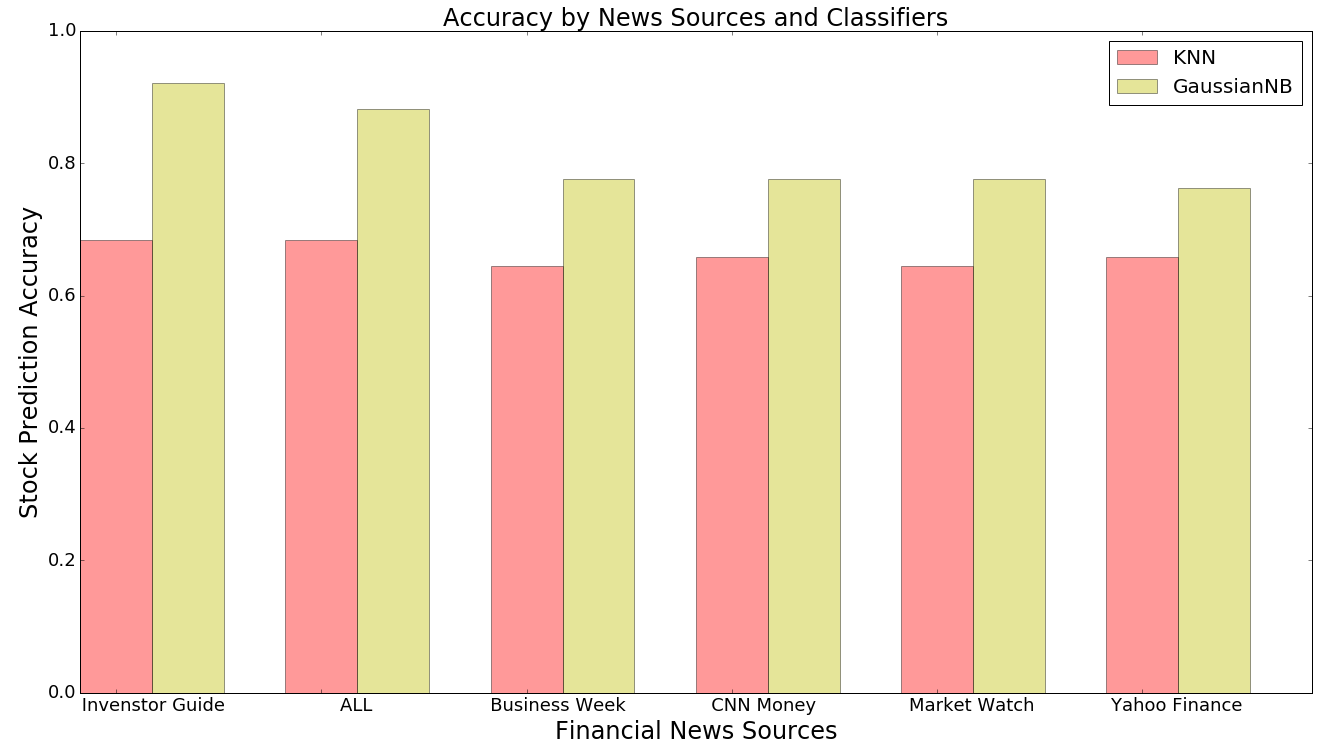

In [198]:
"""
Bar chart demo with pairs of bars grouped for easy comparison.
"""
import numpy as np
import matplotlib.pyplot as plt

axis_font = {'fontname':'Arial', 'size':'24'}
axis_font2 = {'fontname':'Arial', 'size':'18'}


# 'Business Week', 'CNN Money', 'Invenstor Guide', 'Market Watch', 'Yahoo Finance']
n_groups = 6

#KNN_accuracy = (0.645, 0.658, 0.684, 0.645, 0.658, 0.684)
KNN_accuracy = (0.684, 0.684, 0.645, 0.658, 0.645, 0.658)


#BNB_accuracy = (0.776, 0.776, 0.921, 0.776, 0.763, 0.882)
BNB_accuracy = (0.921, 0.882, 0.776, 0.776, 0.776, 0.763)


fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, KNN_accuracy, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='KNN')

rects2 = plt.bar(index + bar_width, BNB_accuracy, bar_width,
                 alpha=opacity,
                 color='y',
                 error_kw=error_config,
                 label='GaussianNB')

plt.xlabel('Financial News Sources', **axis_font)
plt.ylabel('Stock Prediction Accuracy', **axis_font)
plt.title('Accuracy by News Sources and Classifiers', **axis_font)
plt.xticks(index + bar_width / 2, ('             Invenstor Guide', '            ALL', '           Business Week', '           CNN Money',\
                                   '            Market Watch', '            Yahoo Finance'), **axis_font2) 
plt.yticks(**axis_font2)
plt.legend(prop={'size':20})

plt.tight_layout()
plt.savefig('Accuracy_News_Classifiers.png')
plt.show()